In [1]:
import qiskit as qsk, numpy as np, matplotlib.pyplot as plt
import torch
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor, Resize
from qiskit.quantum_info import SparsePauliOp, Statevector, Clifford, PauliList
from typing import Callable

def random_thetas(shape: "shape"):
    possible_theta_values = np.pi / 2 * np.arange(4)
    print(possible_theta_values)
    print(shape)
    return np.random.choice(possible_theta_values, shape)

def evolveSPO(op: SparsePauliOp, other: Clifford) -> SparsePauliOp:
    return SparsePauliOp(
        op.paulis.evolve(other)
    )

def img_to_vec(image: torch.Tensor):
    n = int(np.log2(image.shape[0]))  # Image should be a 2^n x 2^n tensor
    image = image.reshape([2 for i in range(2*n)])  # Convert tensor indices from y,x to y0,y1,...,yn-1,x0,x1,...,xn-1
    image = image.permute([i+j for i in range(n) for j in [0, n]])  # Permute indices from y0,y1,...,yn-1,x0,x1,...,xn-1 to y0,x0,y1,x1,...,yn-1,xn-1
    vec = image.flatten()
    return np.array([x for x in vec])

class ParametricCircuit:
    def __init__(self):
        self.n_parameters: int = None
        self.params_shape: "shape" = None
    
    def __call__(self, thetas: np.ndarray, *args, **kwds) -> qsk.QuantumCircuit:
        pass

class Model:
    def __init__(self,
                 parametric_circuit: ParametricCircuit,
                 encoding: Callable[..., Statevector],
                 observable: SparsePauliOp
                 ):
        self.param_circ = parametric_circuit
        self.enc = encoding
        self.obs = observable
        self.use_inefficient_method: bool = False

    # def inefficient_call(self, thetas: np.ndarray, input) -> float:
    #     psi = self.enc(input)
    #     qc = self.param_circ(thetas)
    #     evolved_psi = psi.evolve(qc)
    #     return evolved_psi.expectation_value(self.obs)

    def __call__(self, thetas: np.ndarray, input) -> float:
        psi = self.enc(input)
        qc = self.param_circ(thetas)
        if self.use_inefficient_method == False:
            evolved_ops = evolveSPO(self.obs, Clifford(qc))
            return psi.expectation_value(evolved_ops)
        else:
            evolved_psi = psi.evolve(qc)
            return evolved_psi.expectation_value(self.obs)
    
    def param_shift_rule_grad(self, thetas: np.ndarray, input, index: tuple[int]) -> float:
        # print(f"Relevant theta = {thetas[index]}")
        thetas[index] += np.pi / 2
        # print(f"Relevant theta = {thetas[index]}")
        value_plus = self.__call__(thetas, input)
        # print(f"Value plus = {value_plus}")
        thetas[index] -= np.pi
        # print(f"Relevant theta = {thetas[index]}")
        value_minus = self.__call__(thetas, input)
        thetas[index] += np.pi/2
        # print(f"Value minus = {value_minus}")
        return (value_plus - value_minus) / 2
    
    def empirical_NTK(self, thetas: np.ndarray, input1, input2) -> float:
        grad = self.param_shift_rule_grad
        # print(
        #     np.array([
        #         self.param_shift_rule_grad(thetas, input1, index) #* grad(thetas, input2, index)
        #         for index in np.ndindex(thetas.shape)
        #     ])
        # )
        return np.sum([
            grad(thetas, input1, index) * grad(thetas, input2, index)
            for index in np.ndindex(thetas.shape)
        ])
    
    def analytic_NTK(self, input1, input2, n_shots):
        return np.mean([
            self.empirical_NTK(random_thetas(self.param_circ.params_shape),
                               input1, input2)
            for _ in range(n_shots)
        ])


class SimpleTestCircuit(ParametricCircuit):
    def __init__(self, n_qubits: int):
        self.n_parameters: int = n_qubits
        self.params_shape: tuple[int] = (n_qubits)
    
    def __call__(self, thetas: np.ndarray) -> qsk.QuantumCircuit:
        qc = qsk.QuantumCircuit(self.n_parameters)
        for i in range(self.n_parameters): qc.rx(thetas[i], i)
        return qc

class ConvolutionalQNN(ParametricCircuit):
    def __init__(self, n_qubits: int, n_layers: int):
        self.qc: qsk.QuantumCircuit = None
        self.n_qubits: int = n_qubits
        self.n_layers: int = n_layers
        self.params_shape: tuple[int] = (4, 5*n_qubits//2 - 4, n_layers)
        self.n_parameters: int = np.prod(self.params_shape)

    def elementary_2_qubit_gate(self, thetas: np.ndarray, qubit1: int, qubit2: int):
        self.qc.rx(thetas[0], qubit1)
        self.qc.rx(thetas[1], qubit2)
        self.qc.cx(qubit1, qubit2)
        self.qc.rz(thetas[2], qubit1)
        self.qc.rz(thetas[3], qubit2)
    
    def layer(self, thetas: np.ndarray):
        i = 0
        def apply_gate(qubit1: int, qubit2: int):
            nonlocal i
            self.elementary_2_qubit_gate(thetas[:, i], qubit1, qubit2)
            i += 1
        
        def xiyi_gates(central_qubit: int):
            if central_qubit>0: apply_gate(central_qubit-2, central_qubit-1)
            apply_gate(central_qubit, central_qubit+1)
            if central_qubit<self.n_qubits-2: apply_gate(central_qubit+2, central_qubit+3)
        
        def xxyy_gates(lower_qubit: int):
            apply_gate(lower_qubit, lower_qubit+2)
            apply_gate(lower_qubit+1, lower_qubit+3)
        
        for qubit in np.arange(0, self.n_qubits-2, 2):
            xiyi_gates(qubit)
            xxyy_gates(qubit)
        xiyi_gates(self.n_qubits-2)
    
    def __call__(self, thetas):
        self.qc = qsk.QuantumCircuit(self.n_qubits)
        for i in range(self.n_layers):
            self.layer(thetas[:,:,i])
            self.qc.barrier()
        return self.qc









[0.         1.57079633 3.14159265 4.71238898]
(4, 21, 3)


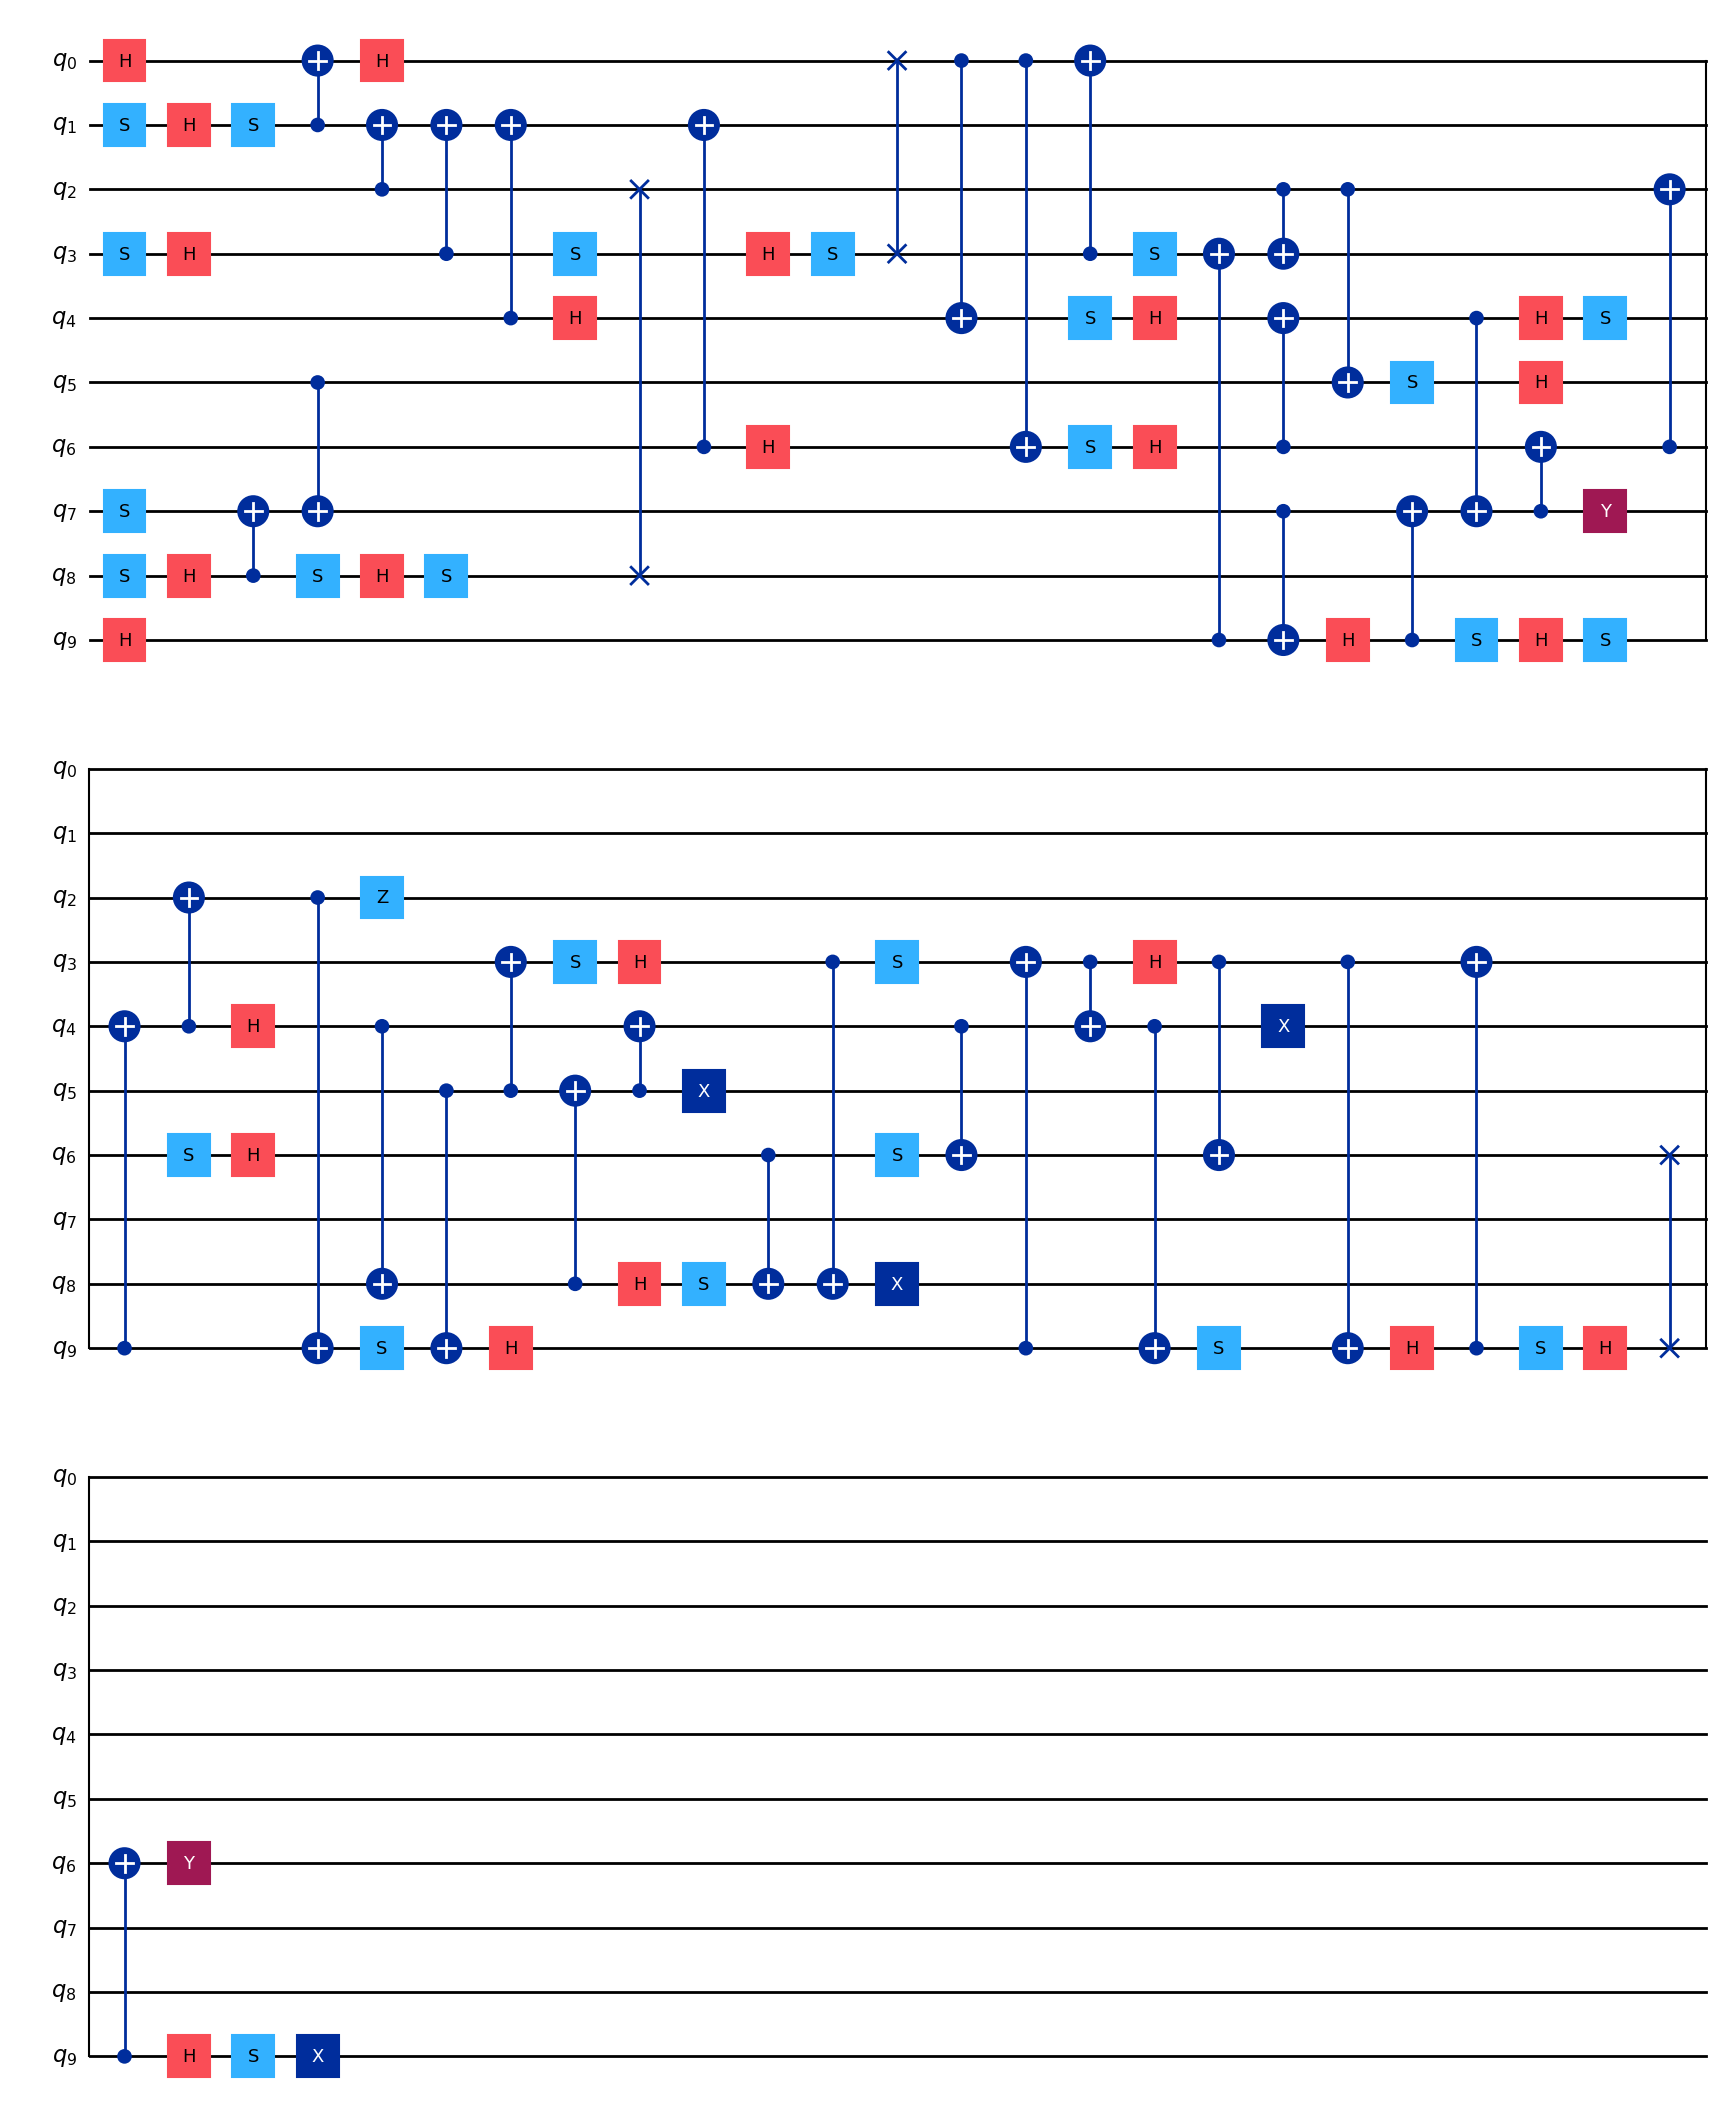

In [7]:
# thetas = np.zeros((4, 21, 3))
thetas = random_thetas((4,21,3))
pc = ConvolutionalQNN(10, 3)
# with open("circuit.txt", "w") as f:
#     print(pc(thetas).draw("mpl"), file = f)
Clifford(pc(thetas)).to_circuit().draw("mpl")

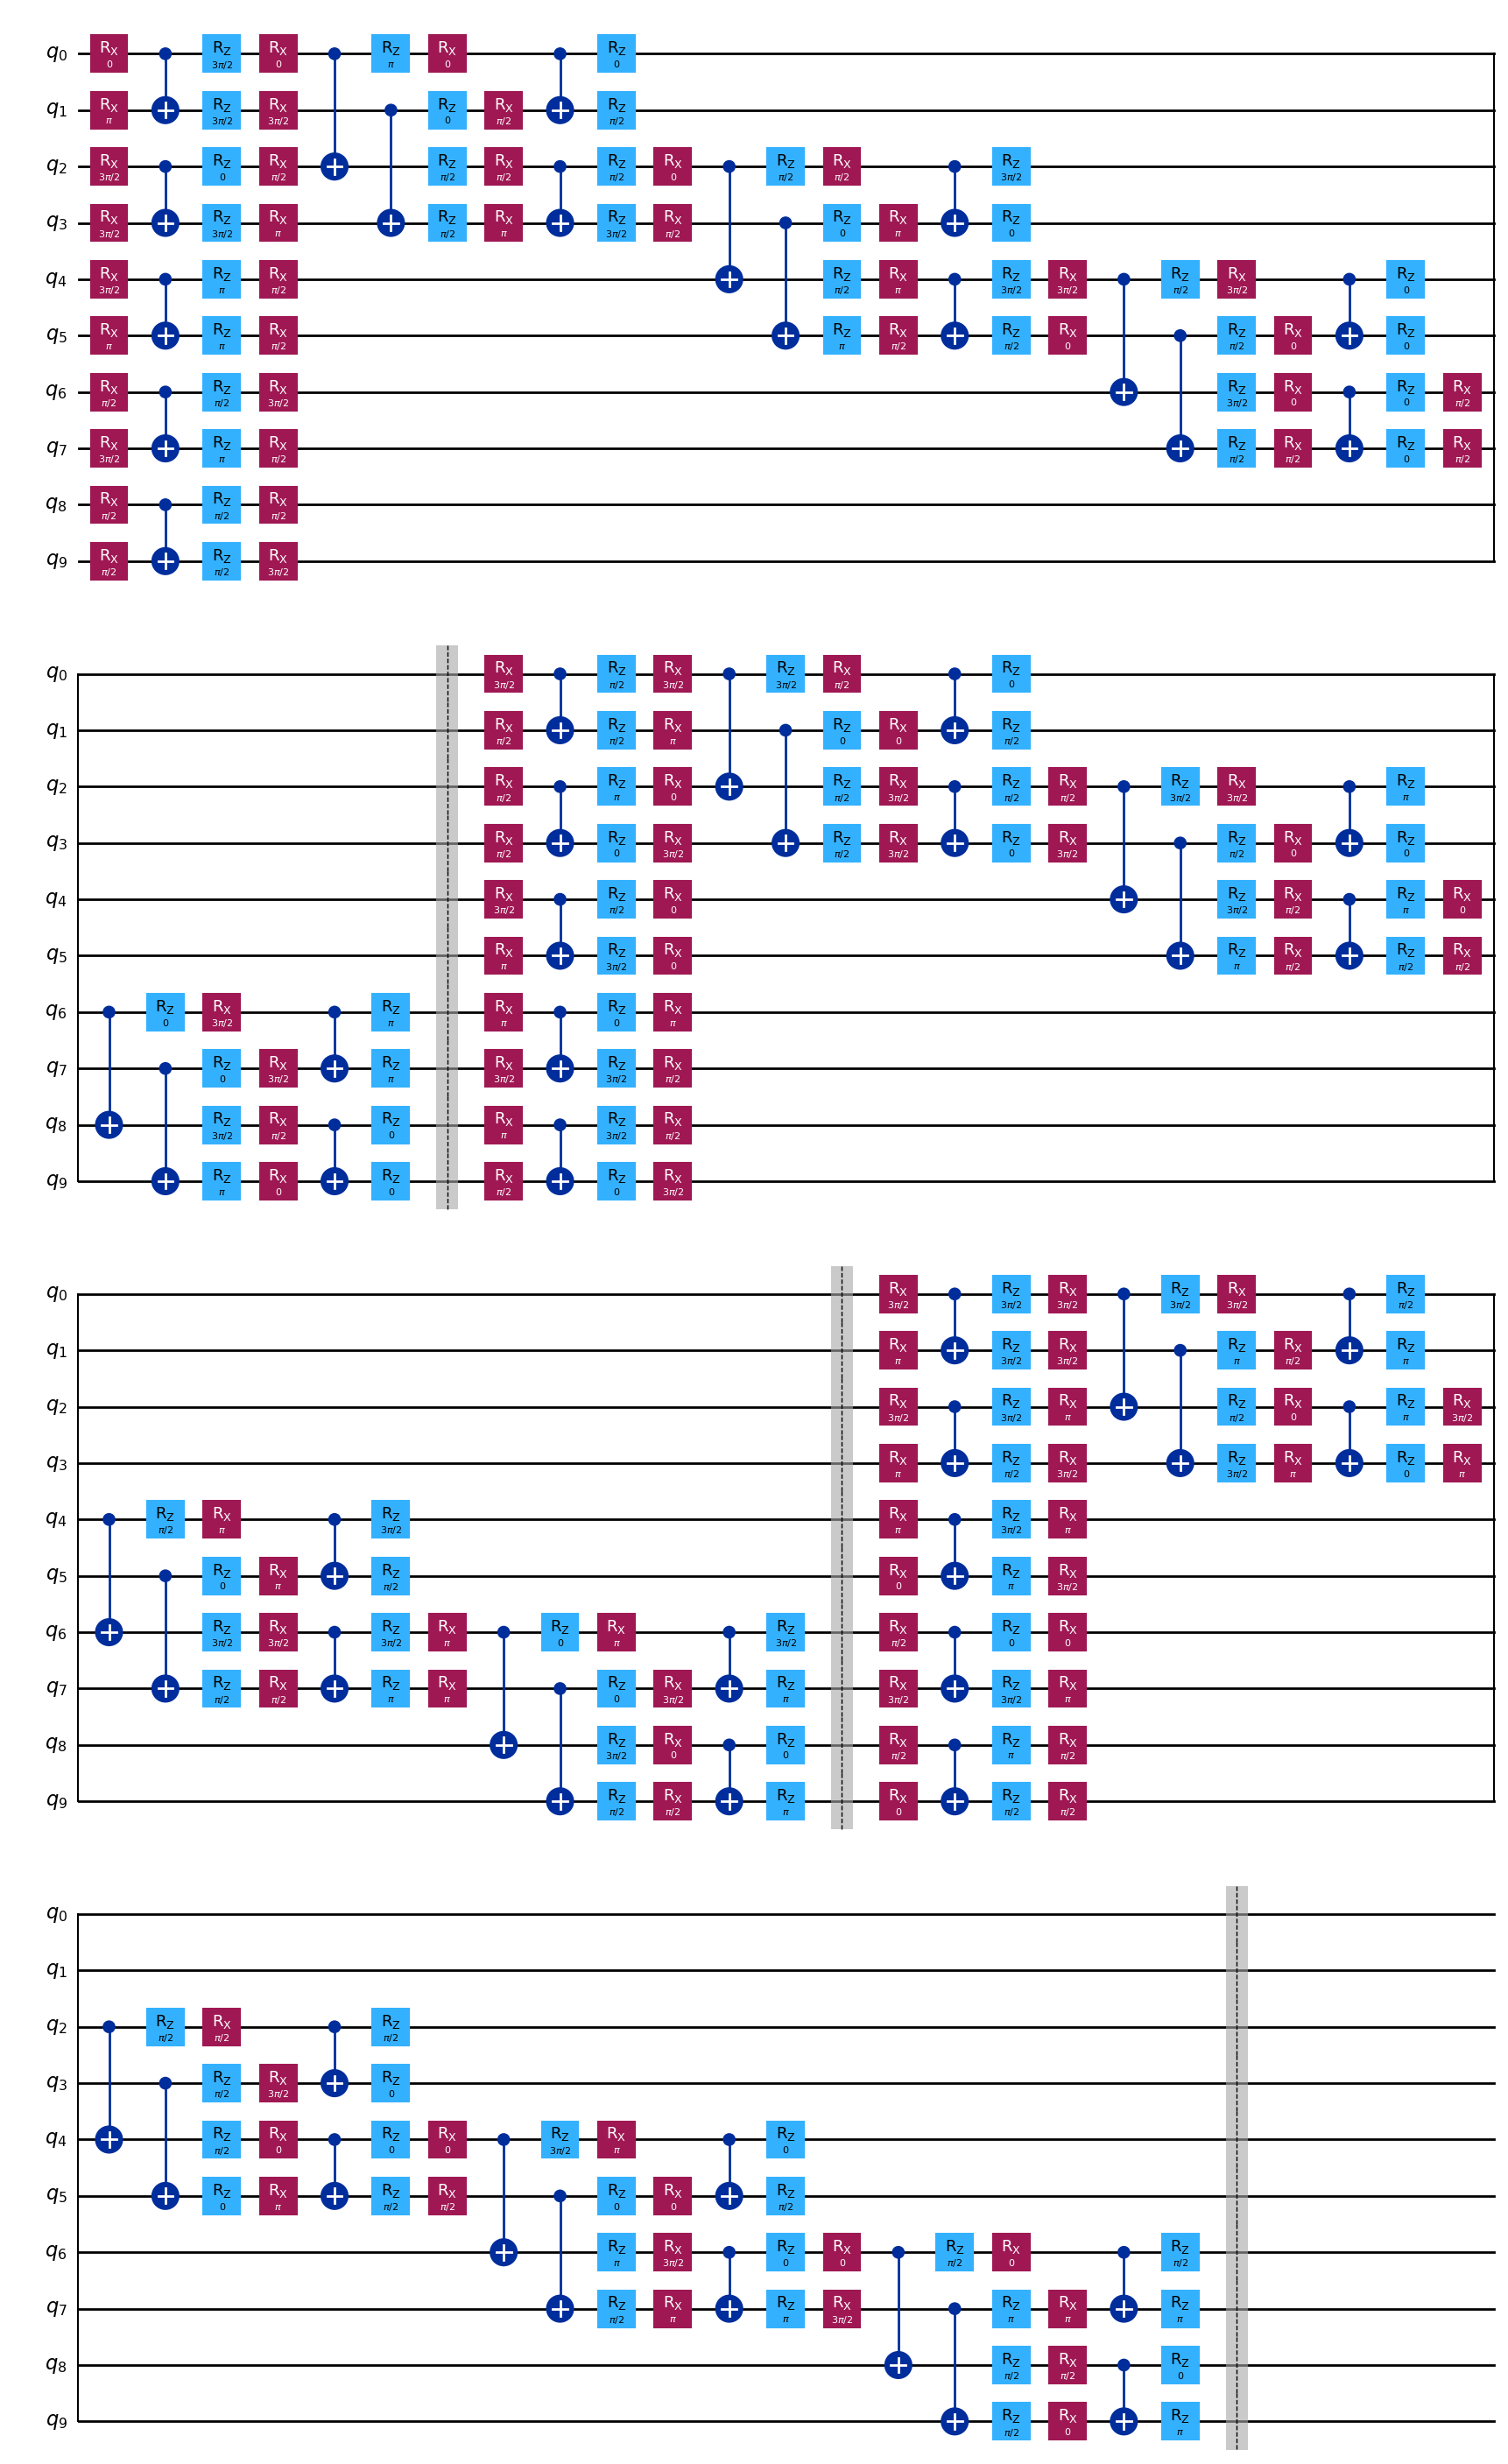

In [4]:
pc(thetas).draw("mpl")

In [8]:
def basis_encoding(int: int, n_qubits: int) -> Statevector:
    return Statevector.from_int(int, 2**n_qubits)

def sumZ(n_qubits: int) -> SparsePauliOp:
    return SparsePauliOp.from_sparse_list(
        [("Z", [i], 1) for i in range(n_qubits)],
        num_qubits = n_qubits
    )

n_qubits = 5

simple_model = Model(
    SimpleTestCircuit(n_qubits),
    lambda i: basis_encoding(i, n_qubits),
    sumZ(n_qubits)
)

In [9]:
def char(i,j):
    return "Z" if i==j else "I"
''.join([char(i, 1) for i in range(10)])

'IZIIIIIIII'

Note: o._evolve_clifford is faster than o.evolve (12.2s vs 11.9s for 1000 reps... nvm they are equally fast idk why before it was 1.1s vs 2.0s for 100 reps)

In [ ]:
o = PauliList([
    ''.join([char(i, j) for i in range(10)]) for j in range(10)
])
for _ in range(1):
    o_evolved = o.evolve(Clifford(pc(thetas)))
spo = SparsePauliOp(o)
print(o)
print(o_evolved)
print(spo)

['ZIIIIIIIII', 'IZIIIIIIII', 'IIZIIIIIII', 'IIIZIIIIII', 'IIIIZIIIII',
 'IIIIIZIIII', 'IIIIIIZIII', 'IIIIIIIZII', 'IIIIIIIIZI', 'IIIIIIIIIZ']
['XIXYIXZZZY', '-ZXZZZZIXXI', '-ZYZXZXZIZX', '-IIZYXXIYXZ', '-ZYYYZZXZII',
 '-IIYXIZYZZY', '-XXYXXIXIIZ', '-XXYIIZIIII', 'IIIZIZYZYI', 'IIIIIIXIXI']
SparsePauliOp(['ZIIIIIIIII', 'IZIIIIIIII', 'IIZIIIIIII', 'IIIZIIIIII', 'IIIIZIIIII', 'IIIIIZIIII', 'IIIIIIZIII', 'IIIIIIIZII', 'IIIIIIIIZI', 'IIIIIIIIIZ'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
 1.+0.j])


[0. 0. 0. ... 0. 0. 0.]


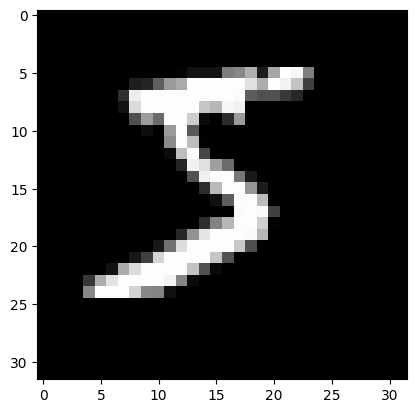

In [12]:
mnist_train = MNIST("./data",
                    train= True,
                    transform= ToTensor(),
                    download= True)

def get_image(idx: int, dataset):
    image, label = dataset[idx]
    size = 32
    padded_image = torch.zeros([size, size])
    padded_image[:28, :28] = image.squeeze()[:, :]
    return padded_image

img1 = get_image(0, mnist_train)
vec1 = img_to_vec(img1)
psi1 = Statevector(vec1)

plt.imshow(img1, cmap = 'gray')
print(vec1)

In [14]:
print(psi1)
print(o)

Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2))
['ZIIIIIIIII', 'IZIIIIIIII', 'IIZIIIIIII', 'IIIZIIIIII', 'IIIIZIIIII',
 'IIIIIZIIII', 'IIIIIIZIII', 'IIIIIIIZII', 'IIIIIIIIZI', 'IIIIIIIIIZ']


Note: psi.expectation_value() is slower than psi._expectation_value_pauli()

In [15]:
for _ in range(100):
    cliff_qc = Clifford(pc(thetas))

= Important

*Clifford(qc) is slow and seems to be the bottleneck. The cell below takes 1.4s to be run with cliff_qc and 12.7s to be run with Clifford(pc(thetas))!!!*

In [17]:
for _ in range(1000):
    o_evolved = o._evolve_clifford(
        cliff_qc
        #Clifford(pc(thetas))
        )
    print(np.sum([
        psi1._expectation_value_pauli(o_evolved[i]) for i in range(len(o_evolved))
    ]))

(42.403568522404846+0j)
(42.403568522404846+0j)
(42.403568522404846+0j)
(42.403568522404846+0j)
(42.403568522404846+0j)
(42.403568522404846+0j)
(42.403568522404846+0j)
(42.403568522404846+0j)
(42.403568522404846+0j)
(42.403568522404846+0j)
(42.403568522404846+0j)
(42.403568522404846+0j)
(42.403568522404846+0j)
(42.403568522404846+0j)
(42.403568522404846+0j)
(42.403568522404846+0j)
(42.403568522404846+0j)
(42.403568522404846+0j)
(42.403568522404846+0j)
(42.403568522404846+0j)
(42.403568522404846+0j)
(42.403568522404846+0j)
(42.403568522404846+0j)
(42.403568522404846+0j)
(42.403568522404846+0j)
(42.403568522404846+0j)
(42.403568522404846+0j)
(42.403568522404846+0j)
(42.403568522404846+0j)
(42.403568522404846+0j)
(42.403568522404846+0j)
(42.403568522404846+0j)
(42.403568522404846+0j)
(42.403568522404846+0j)
(42.403568522404846+0j)
(42.403568522404846+0j)
(42.403568522404846+0j)
(42.403568522404846+0j)
(42.403568522404846+0j)
(42.403568522404846+0j)
(42.403568522404846+0j)
(42.403568522404

In [18]:
for _ in range(100):
    psi1_evolved = psi1.evolve(pc(thetas))
    print(np.sum([
        psi1_evolved._expectation_value_pauli(o[i]) for i in range(len(o))
    ]))

42.40356852240473
42.40356852240473
42.40356852240473
42.40356852240473
42.40356852240473
42.40356852240473
42.40356852240473
42.40356852240473
42.40356852240473
42.40356852240473
42.40356852240473
42.40356852240473
42.40356852240473
42.40356852240473
42.40356852240473
42.40356852240473
42.40356852240473
42.40356852240473
42.40356852240473
42.40356852240473
42.40356852240473
42.40356852240473
42.40356852240473
42.40356852240473
42.40356852240473
42.40356852240473
42.40356852240473
42.40356852240473
42.40356852240473
42.40356852240473
42.40356852240473
42.40356852240473
42.40356852240473
42.40356852240473
42.40356852240473
42.40356852240473
42.40356852240473
42.40356852240473
42.40356852240473
42.40356852240473
42.40356852240473
42.40356852240473
42.40356852240473
42.40356852240473
42.40356852240473
42.40356852240473
42.40356852240473
42.40356852240473
42.40356852240473
42.40356852240473
42.40356852240473
42.40356852240473
42.40356852240473
42.40356852240473
42.40356852240473
42.4035685

In [95]:
for _ in range(100000):
    psi1._expectation_value_pauli(o[1])

psi.expectation_value(spo) is slower than psi.expectation_value(o[i]) repeated for each i, furthermore psi._expectation_value_pauli(spo) returns an error, so maybe a SparsePauliOp is computed via the naive way instead of the efficient Pauli way

In [90]:
for _ in range(10000):
    psi1.expectation_value(spo)

In [96]:
def img_to_amp_enc_Statevec(img):
    vec = img_to_vec(img)
    return Statevector(vec)

img_to_amp_enc_Statevec(img1)

Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2))


In [98]:
thetas = random_thetas((4,31,3))

[0.         1.57079633 3.14159265 4.71238898]
(4, 31, 3)


In [102]:
pc = ConvolutionalQNN(14, 3)
model = Model(
    pc,
    lambda img: Statevector(img_to_vec(img)),
    sumZ(14)
)
model.use_inefficient_method = True
model(thetas, img1)
model.empirical_NTK(thetas, img1, img1)

np.complex128(3739.2332443626115+0j)

In [103]:
pc = ConvolutionalQNN(14, 3)
model = Model(
    pc,
    lambda img: Statevector(img_to_vec(img)),
    sumZ(14)
)
model.use_inefficient_method = False
model(thetas, img1)
model.empirical_NTK(thetas, img1, img1)

np.complex128(3739.233244362639+0j)

The computation of 1 empirical NTK required 13.9 ~ 15.6 seconds with the Clifford-based method.

Let's see the advantage wrt the full-matrix method

It takes 9.5 secs.

I'm surprised it's less. Why does it happen & how can we push the Clifford-method time below the stupid method?

Let's try if it keeps happening with more qubits

At 14 qubits, the inefficient, naive method takes 2m54s, the Clifford method takes 2m34s (just because I forgot to change sumZ(10) to sumZ(14))

2nd try: 3m20s vs 2m46s (again, a problem)

This is a problem.

In [3]:
thetas = np.zeros(n_qubits)
thetas[0] = np.pi/2
print(thetas)
display(simple_model.param_circ(thetas).draw("text"))
print(simple_model(thetas, 0))
print(simple_model.param_shift_rule_grad(thetas, 0, (0)))
print(f"theatas after \n{thetas}")
print(simple_model.empirical_NTK(thetas, 0, 0))

[1.57079633 0.         0.         0.         0.        ]


┌─────────┐
q_0: ┤ Rx(π/2) ├
     └┬───────┬┘
q_1: ─┤ Rx(0) ├─
      ├───────┤ 
q_2: ─┤ Rx(0) ├─
      ├───────┤ 
q_3: ─┤ Rx(0) ├─
      ├───────┤ 
q_4: ─┤ Rx(0) ├─
      └───────┘

(4+0j)
(-1+0j)
theatas after 
[1.57079633 0.         0.         0.         0.        ]
(1+0j)


Note: computing the analytic NTK of the simple model,
on $500$ shots, for any pair of input integers, using
```
f:
P' = P.evolve(Clifford(qc))
return psi.expectation_value(P')
```
takes $\sim 8 s$.

Computing it using

```
f:
psi' = psi.evolve(qc)
return psi'.expectation_value(P)
```
takes only $\sim 2 s$ instead

This is unexpected to hold for the bigger, convolutional model,
however it's worth investigating why the Pauli-evolving method is
slower than the state-evolving method in the simple case
(overhead in the conversion `qc` $\mapsto$ `Clifford(qc)`?)

In [ ]:
simple_model.analytic_NTK(0,1, 500)

np.complex128(1.528+0j)